In [1]:
using DifferentialEquations
using Plots
using DiffEqSensitivity
using ForwardDiff
using GlobalSensitivity
using Statistics
using Printf

In [2]:
function model(du,u,p,t)
    
    # PARAMATERS
    # Load paramaters
    organic_carbon_input = p[1]
    inorganic_carbon_input = p[2]
    natural_death_fraction = p[3]
    ks = p[4]
    organic_carbon_content_per_cell = p[5]
    inorganic_carbon_content_per_cell = p[6]
    mu_max = p[7]
    base_maintenance_per_cell = p[8]
    inorganic_carbon_fixing_factor = p[9]
    carrying_capacity = p[10]
    

    # Load state conditions
    organic_carbon_content = u[1]
    inorganic_carbon_content = u[2]
    cell_count = u[3]


    ## CELL COUNT
    # Growth
    growth = mu_max * (organic_carbon_content / (ks + organic_carbon_content)) * cell_count * (1 - cell_count / carrying_capacity)

#     # Specific growth rate
#     next_cell_count = cell_count + growth
#     specific_growth_rate = 0
#     if next_cell_count > 0 && cell_count > 0
#         specific_growth_rate = max((np.log(next_cell_count) - np.log(cell_count)), 0)
#     end

    # Organic carbon requirement
    required_organic_carbon_per_cell = base_maintenance_per_cell  #+ m_prime * (1 - specific_growth_rate/mu_max)
    required_organic_carbon = required_organic_carbon_per_cell * cell_count

    # Starvation
    organic_carbon_missing = max(required_organic_carbon - organic_carbon_content, 0)
    
    starvation_deaths = organic_carbon_missing == 0 ? 0 : organic_carbon_missing / required_organic_carbon_per_cell

    # Natural Death
    natural_deaths = natural_death_fraction * cell_count - natural_death_fraction * starvation_deaths

    # Deaths
    deaths = natural_deaths + starvation_deaths

    # Net cell count change
    du[3] = growth - deaths

    ## CARBON
    carbon_consumption = required_organic_carbon_per_cell * (cell_count - deaths)
    fixed_carbon = inorganic_carbon_fixing_factor * inorganic_carbon_content

    # Inorganic carbon
    du[2] = inorganic_carbon_input + inorganic_carbon_content_per_cell * (
            deaths - growth) + carbon_consumption - fixed_carbon

    # Organic carbon
    du[1] = organic_carbon_input + organic_carbon_content_per_cell * (
            deaths - growth) - carbon_consumption + fixed_carbon
    
end

model (generic function with 1 method)

In [6]:
p = [0, 0.0, 0.001, 882000000.0, 140.0, 0.0, 0.06, 2.1739130434782608, 0.0, 1000000000.0]
duration = 11000 * 365.25 # In days

u0 = [1286820000000.0; 0.0; 100000.0]
tspan = (0.0, duration)
prob = ODEProblem(model,u0,tspan,p)
# sol = solve(prob, reltol=1e-9, abstol=1e-9)

# S = plot(sol, vars=(1), yaxis="Organic C")
# I = plot(sol, vars=(2), yaxis="Inorganic C")
# N = plot(sol, vars=(3), yaxis="Cells")


# plot(plot(N),plot(I, S, layout=(1,2)), layout=(2,1))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 4.01775e6)
u0: 3-element Vector{Float64}:
      1.28682e12
      0.0
 100000.0

In [4]:
p_names = ["OC input", "IC input", "Death rate", "Ks", "OC/cell", "IC/cell", "mu", "M.E.", "IC fixing factor", "carrying capacity"]
p_range = [[0, 0], [0, 0], [0.001, 0.001], [0.001, 10000000000], [0, 500], [0, 500], [0.000000001, 0.1], [0, 400], [0, 1], [1000000000, 1000000000]]


f1 = function (p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1, Rosenbrock23(); saveat=collect(range(0, stop=duration, length=200)), maxiters=Int(1e6))
  [last(sol[1,:])]
end

sobol_result = GlobalSensitivity.gsa(f1, Sobol(), p_range, N=1000)

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = (::DefaultLinSolve)(x::Vector{Float64}, A::Matrix{Float64}, b::Vector{Float64}, update_matrix::Bool; reltol::Float64, kwargs::Base.Pairs{Symbol, DiffEqBase.ScaleVector{Vector{Float64}}, Tuple{Symbol, Symbol}, NamedTuple{(:Pl, :Pr), Tuple{DiffEqBase.ScaleVector{Vector{Float64}}, DiffEqBase.ScaleVector{Vector{Float64}}}}}) at linear_nonlinear.jl:91
└ @ DiffEqBase /Users/GeorgesKanaan/.julia/packages/DiffEqBase/niZxn/src/linear_nonlinear.jl:91


GlobalSensitivity.SobolResult{Matrix{Float64}, Nothing, Nothing, Nothing}([0.0 0.0 … 0.3434353459963592 0.0], nothing, nothing, nothing, [0.0 0.0 … 0.4352641954327524 0.0], nothing)

Total order indices:
OC input: Fixed value
IC input: Fixed value
Death rate: Fixed value
Ks: 0.000
OC/cell: 0.129
IC/cell: 0.143
mu: 0.164
M.E.: 0.317
IC Fix. %: 0.435
carrying capacity: Fixed value

First order indices:
OC input: Fixed value
IC input: Fixed value
Death rate: Fixed value
Ks: -0.000
OC/cell: 0.106
IC/cell: 0.098
mu: 0.152
M.E.: 0.236
IC Fix. %: 0.343
carrying capacity: Fixed value


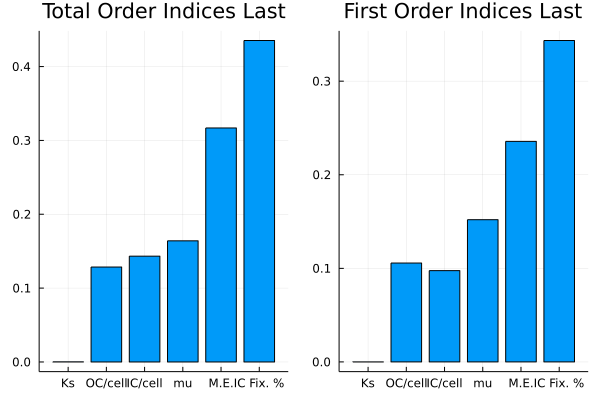

In [5]:
p_names = ["OC input", "IC input", "Death rate", "Ks", "OC/cell", "IC/cell", "mu", "M.E.", "IC Fix. %", "carrying capacity"]


p_names_final = []
sobol_result_st = []
sobol_result_s1 = []

println("Total order indices:")
for (index, value) in enumerate(sobol_result.ST[1,:])
    if p_range[index][1] == p_range[index][2]
        println(p_names[index] * ": Fixed value")
    else
        @printf("%s: %.3f\n", p_names[index], value)
        push!(p_names_final, p_names[index])
        push!(sobol_result_st, value)
    end
end

println("")
println("First order indices:")

for (index, value) in enumerate(sobol_result.S1[1,:])
    if p_range[index][1] == p_range[index][2]
        println(p_names[index] * ": Fixed value")
    else
        @printf("%s: %.3f\n", p_names[index], value)
        push!(sobol_result_s1, value)
    end
end

p1 = bar(p_names_final, sobol_result_st, title="Total Order Indices Last",legend=false)
p2 = bar(p_names_final, sobol_result_s1, title="First Order Indices Last",legend=false)

plot(p1, p2)